In [ ]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=KhcIXmGB9qiqYSurmEd1OE7ai1gsoY&access_type=offline&code_challenge=FXd8t_iNJ1Smwus7s7YNkiZ2VgOos-bXrFHWGHwaAs8&code_challenge_method=S256


Credentials saved to file: [/Users/yt4/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "open-targets-genetics-dev" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [ ]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=UiDTZiS2COSkwLlSyy0l1pVKoF8Yfg&access_type=offline&code_challenge=4jMAWGLzSEe-ozTnSiVWYKCSv6hg9PyZzX727eiHbYk&code_challenge_method=S256


You are now logged in as [yt4@sanger.ac.uk].
Your current project is [open-targets-genetics-dev].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



In [1]:
import os

import hail as hl
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.study_locus import StudyLocus
from gentropy.susie_finemapper import SusieFineMapperStep
from gentropy.method.drug_enrichment_from_evid import chemblDrugEnrichment

"""Common utilities for the project."""

import os
from pathlib import Path
from gentropy.common.session import Session
import logging


def get_gcs_credentials() -> str:
    """Get the credentials for google cloud storage."""
    app_default_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/application_default_credentials.json"
    )

    service_account_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/service_account_credentials.json"
    )

    if Path(app_default_credentials).exists():
        return app_default_credentials
    else:
        raise FileNotFoundError("No GCS credentials found.")


def get_gcs_hadoop_connector_jar() -> str:
    """Get the google cloud storage hadoop connector for spark.

    This function will return the url to download the hadoop jar.
    """

    return (
        "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar"
    )


def gcs_conf(
    credentials_path=None, project="open-targets-genetics-dev"
) -> dict[str, str]:
    """Get the spark configuration with hadoop connector for google cloud storage."""
    credentials_path = credentials_path or get_gcs_credentials()
    return {
        "spark.driver.memory": "12g",
        "spark.kryoserializer.buffer.max": "500m",
        "spark.driver.maxResultSize":"2g",
        "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
        "spark.jars": get_gcs_hadoop_connector_jar(),
        "spark.hadoop.google.cloud.auth.service.account.enable": "true",
        "spark.hadoop.fs.gs.project.id": project,
        "spark.hadoop.google.cloud.auth.service.account.json.keyfile": credentials_path,
        "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",
    }


class GentropySession(Session):
    def __init__(self, *args, **kwargs):
        if "extended_spark_conf" in kwargs:
            kwargs["extended_spark_conf"].update(gcs_conf())
        else:
            kwargs["extended_spark_conf"] = gcs_conf()
        super().__init__(*args, **kwargs)

    @property
    def conf(self):
        logging.warning(
            "To change the config restart the session and use the `extended_spark_conf` parameter."
        )
        return self.spark.sparkContext.getConf().getAll()

session= GentropySession()


path_to_release_folder="gs://open-targets-data-releases/25.03/"
#path_to_release_folder="gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/"
#path_to_release_folder="gs://ot_orchestration/releases/25.02_freeze1/"

si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 23:32:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/24 23:32:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/24 23:32:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/04/24 23:32:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


# Feature matrix evidence

In [2]:
fm=session.spark.read.parquet(path_to_release_folder+"intermediate/l2g_feature_matrix/")
fm=fm.filter(f.col("isProteinCoding")==1).cache()
fm.count()

25/04/24 23:33:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


7734143

In [3]:
# combinig it with l2g predictions
l2g=session.spark.read.parquet(path_to_release_folder+"output/l2g_prediction")

In [4]:
combined_df = fm.join(l2g.drop("features","shapBaseValue"), on=["geneId", "studyLocusId"], how="left").fillna(0)

combined_df.count()

7734143

In [5]:
clpp_thr=0.01
coloc_thr=0.8

combined_df = combined_df.withColumn(
    "l2g_005",
    f.when(f.col("score") >= 0.05, 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "eQTL_coloc",
    f.when(
    (f.col("eQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("eQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "pQTL_coloc",
    f.when(
    (f.col("pQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("pQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "sQTL_coloc",
    f.when(
    (f.col("sQtlColocClppMaximum")>=clpp_thr) | 
    (f.col("sQtlColocH4Maximum")>=coloc_thr), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "VEP",
    f.when((f.col("vepMaximum")>=0.66), 1).otherwise(0)
)
combined_df = combined_df.withColumn(
    "distance",
    f.when((f.col("distanceSentinelFootprintNeighbourhood")==1) |
    (f.col("distanceSentinelTssNeighbourhood")==1), 1).otherwise(0)
)

combined_df = combined_df.withColumn(
    "sum_coloc_vep_distance",
    f.col("eQTL_coloc") + f.col("pQTL_coloc") + f.col("sQTL_coloc") + f.col("VEP") + f.col("distance")
)

combined_df = combined_df.withColumn(
    "eQTLs_not_in_L2G",
    f.when((f.col("eQTL_coloc")==1) &
    (f.col("l2g_005")==0), 1).otherwise(0)
).cache()

combined_df.count()

7734143

In [6]:
colnames=["eQTL_coloc","pQTL_coloc","sQTL_coloc","VEP","distance","sum_coloc_vep_distance","eQTLs_not_in_L2G"]

In [7]:
disease_index_path=path_to_release_folder+"output/disease/disease.parquet"
disease_index_orig = session.spark.read.parquet(disease_index_path)

platform_chembl_evidence_path=path_to_release_folder+"output/evidence/sourceId=chembl"
chembl_evidence=session.spark.read.parquet(platform_chembl_evidence_path)

In [8]:
import pandas as pd
all_enrich = []

In [9]:
for coln in colnames:
    print(coln)
    evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=combined_df,
        score_column=coln,
        datasource_id=coln,
        study_locus=sl,
        study_index=si,
        min_score=0.5
    ).cache()
    enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
        evid=evidence,
        disease_index_orig=disease_index_orig,
        chembl_orig=chembl_evidence,
        indirect_assoc_score_thr=0.5,
        efo_ancestors_to_remove=["MONDO_0045024"]
    )
    enrich["datasource"] = coln
    all_enrich.append(enrich)

eQTL_coloc


pQTL_coloc


sQTL_coloc


VEP


distance


sum_coloc_vep_distance


eQTLs_not_in_L2G


In [ ]:
#pQTLS-transpatls
#coln="pQTL_coloc"
#evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=combined_df,
#    score_column=coln,
#    datasource_id=coln,
#    study_locus=sl,
#    study_index=si,
#    min_score=0.5
#)
#filtered_evidence = evidence.join(
#    trsn_pqtls_evidence.select("targetId", "diseaseId"),
#    on=["targetId", "diseaseId"],
#    how="left_anti"
#)
#enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
#    evid=filtered_evidence,
#    disease_index_orig=disease_index_orig,
#    chembl_orig=chembl_evidence, 
#    indirect_assoc_score_thr=0.5,
#    efo_ancestors_to_remove=["MONDO_0045024"]
#)
#enrich["datasource"] = "cis_pQTL"
#all_enrich.append(enrich)

In [10]:
combined_enrich = pd.concat(all_enrich, ignore_index=True)

In [11]:
combined_enrich

,clinicalPhase,odds_ratio,p_value,ci_low,ci_high,no_evid-low_clinphase,no_evid-high_clinphase,yes_evid-low_clinphase,yes_evid-high_clinphase,total_indirect_assoc,datasource
0,2+,1.506217,4.694139e-03,1.126551,2.013837,6111,30819,52,395,475428,eQTL_coloc
1,3+,1.812091,7.085542e-10,1.498576,2.191195,20392,16538,181,266,475428,eQTL_coloc
2,4+,3.175194,2.575596e-24,2.588372,3.895057,32501,4429,312,135,475428,eQTL_coloc
3,2+,2.274356,2.094285e-02,1.103751,4.686470,6155,31122,8,92,40429,pQTL_coloc
4,3+,2.278631,7.102439e-05,1.510047,3.438409,20538,16739,35,65,40429,pQTL_coloc
5,4+,3.893473,3.127336e-09,2.578482,5.879092,32748,4529,65,35,40429,pQTL_coloc
6,2+,1.738724,4.566229e-03,1.166609,2.591408,6136,30977,27,237,281879,sQTL_coloc
7,3+,1.922538,2.044068e-07,1.500052,2.464015,20470,16643,103,161,281879,sQTL_coloc
8,4+,3.399271,3.523711e-17,2.618746,4.412434,32633,4480,180,84,281879,sQTL_coloc
9,2+,3.155833,9.804996e-06,1.759984,5.658734,6151,31023,12,191,121530,VEP


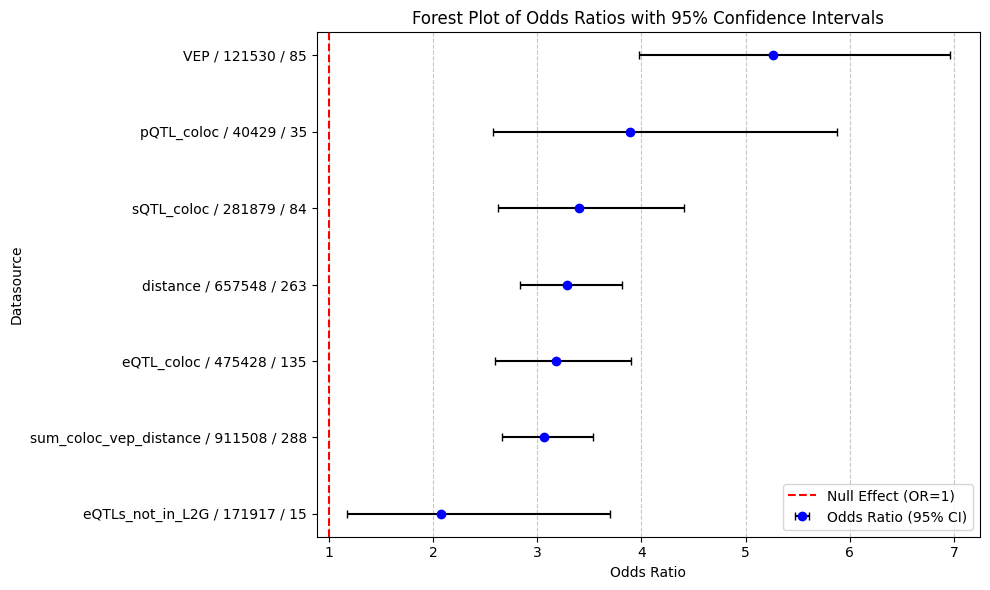

In [12]:
import matplotlib.pyplot as plt

# Assuming `combined_enrich` is your pandas DataFrame
# Sort the DataFrame by odds_ratio for better visualization
combined_enrich_4=combined_enrich[combined_enrich["clinicalPhase"]=="4+"]
combined_enrich_4 = combined_enrich_4.sort_values(by="odds_ratio", ascending=True)

# Extract data for the plot
datasources = combined_enrich_4.apply(
    lambda row: f"{row['datasource']} / {row['total_indirect_assoc']} / {row['yes_evid-high_clinphase']}", axis=1
)
odds_ratios = combined_enrich_4["odds_ratio"]
ci_low = combined_enrich_4["ci_low"]
ci_high = combined_enrich_4["ci_high"]

# Create the forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(odds_ratios, datasources, xerr=[odds_ratios - ci_low, ci_high - odds_ratios], fmt='o', color='blue', ecolor='black', capsize=3, label="Odds Ratio (95% CI)")

# Add labels and title
plt.axvline(x=1, color='red', linestyle='--', label="Null Effect (OR=1)")
plt.xlabel("Odds Ratio")
plt.ylabel("Datasource")
plt.title("Forest Plot of Odds Ratios with 95% Confidence Intervals")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
folder_to_save="chembl_enrichment/"
combined_enrich.to_csv(folder_to_save+"feature_based.csv", index=False)